# Objetivo

A partir dos dados apresentados o objetivo deste notebook é apresentar o passo a passo da limpeza e manipulação dos dados. 
Para realizar a limpeza dos dados e ter maior compreensão destes análises pontuais foram realizadas.

# Datasets

**offers.jsons** - Dataset contém os IDs das ofertas e metadados de cada uma delas:

*  ```id``` [string]: ID da oferta

* ```offertype``` [string]: Tipo da oferta, i.e., BOGO, discount, informational

* ```minvalue``` [int]: Valor mínimo que precisa ser gasto para que a oferta seja ativada

* ```discountvalue``` [int]: Valor do desconto a ser aplicado, caso a oferta seja ativada

* ```duration``` [int]: Tempo durante o qual a oferta está disponível para o cliente agir, i.e., prazo para que o cliente utilize a oferta recebida


**customers.jsons** - Dataset contém informações sobre aproximadamente 17k clientes:

* ```id``` [string]: ID do cliente

* ```age``` [int]: Idade do cliente no momento da criação da conta

* ```registered_on``` [string]: Data em que o cliente criou a conta

* ```gender``` [string]: gênero do cliente (algumas entradas podem conter '0' para outras opções além de M ou F)

* ```credit_card_limit``` [float]: Limite do cartão de crédito do cliente registrado no momento da criação da conta.

**transactions.jsons** - Dataset contém informações sobre aproximadamente 300k eventos:

* ```account_id``` [string]: ID do cliente

* ```event``` [string]: Descrição do evento (transação, oferta recebida, oferta visualizada, oferta concluída)

* ```time_since_test_start``` [int]: Tempo passado desde o começo do teste, em dias. Os dados começam em t=0

* ```value ``` [json]: Pode registrar o offer_id de oferta, o desconto concedido (reward) ou o valor da transação, dependendo do tipo de evento
    * ```offer id``` [string]
    * ```offer_id``` [string]
    * ```amount``` [float]
    * ```reward``` [float]

**Importante:** Os descontos de uma oferta (key reward do campo value) são concedidos quando uma transação é realizada após a visualização de uma oferta. Nesse caso, o reward recebido será automaticamente aplicado à próxima transação. Logo, o valor da transação seguinte ao recebimento do desconto de uma oferta é o valor com o desconto já aplicado.

# Modelagem do dataset de transação

Dado o comentário:

*Os descontos de uma oferta (key reward do campo value) são concedidos quando uma transação é realizada após a visualização de uma oferta. Nesse caso, o reward recebido será automaticamente aplicado à próxima transação. Logo, o valor da transação seguinte ao recebimento do desconto de uma oferta é o valor com o desconto já aplicado.*

Podemos inferir que a ordem ideal que os eventos podem acontecer é: 

```offer_received``` >> ```offer_viewed``` >> ```transaction``` >> ```offer_completed```

Partindo dessa ordem ideal, tem-se as seguintes informações: 

- ```offer_received```: O cliente recebe a oferta, mas nsse ponto não há desconto aplicado. O ```reward``` ainda não foi conquistado, apenas a oferta foi disponibilizada ao cliente.

- ```offer_viewed```: Quando o cliente visualiza a oferta, cria-se a condição para que ele possa ganhar o ```reward```. Entretanto, após a visualização, o desconto ainda não está aplicado a nenhuma transação.

- ```transaction``` (após a oferta ter sido vista): Quando o cliente realiza uma transação depois de ter visto a oferta, esse ato faz com que o ```reward``` seja efetivamente “ganho”. Neste momento, a oferta é considerada pronta para ser concluída, mas o desconto ainda não é aplicado nesta transação atual. O ato de comprar após visualizar a oferta é o passo necessário para que o sistema marque essa oferta como utilizável.

- ```offer_completed```: Com a realização da transação subsequente à visualização, a oferta é finalizada, o ```reward``` é concedido ao cliente. Significa que, agora, o sistema disponibiliza o desconto para ser utilizado.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("ggplot")

In [2]:
def check_offer_ids(row):
    id1 = row["offer id"]
    id2 = row["offer_id"]

    if pd.isna(id1) and pd.isna(id2):
        return "flag_both_null"
    if not pd.isna(id1) and not pd.isna(id2):
        return "flag_both_not_null" if id1 == id2 else "flag_different"
    return "flag_id_1_not_null" if not pd.isna(id1) else "flag_id_2_not_null"

In [3]:
def associate_transactions_to_offers(
    transactions: pd.DataFrame, offers_duration: pd.DataFrame
) -> pd.DataFrame:

    transactions = transactions.merge(offers_duration, on="offer_id", how="left")
    transactions = transactions.sort_values(
        by=["customer_id", "offer_id", "time_since_test_start"]
    )
    
    for customer in transactions["customer_id"].unique():
        # Filter current client
        customer_df = transactions[transactions["customer_id"] == customer].copy()

        # Get the received offers
        received_offers = customer_df[customer_df["event"] ==  "offer received"]

        for _, offer in received_offers.iterrows():
            offer_id = offer["offer_id"]
            start_time = offer["time_since_test_start"]
            duration = offer["duration"]
            end_time = start_time + duration

            # Associate the transactions with the influence window
            transactions_idx = customer_df[
                (customer_df["event"] == "transaction")
                & (customer_df["time_since_test_start"] >= start_time)
                & (customer_df["time_since_test_start"] <= end_time)
                & (customer_df["offer_id"].isna())
            ].index

            transactions.loc[transactions_idx, "offer_id"] = offer_id

    return transactions

In [4]:
def calculate_time(transactions: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the time to view and complete an offer, ensuring the offer was viewed,
    and handle negative time_to_complete values by setting them as None.

    Args:
        transactions (pd.DataFrame): Transaction data with columns: customer_id, offer_id, event, time_since_test_start.

    Returns:
        pd.DataFrame: Processed data with calculated time_to_view and time_to_complete.
    """
    transactions = transactions.sort_values(
        by=["customer_id", "offer_id", "time_since_test_start"]
    )
    # Filter the received offers
    received_offers = transactions[transactions["event"] == "offer received"].copy()

    time_to_view = []
    time_to_complete = []

    for _, received_offer in received_offers.iterrows():
        offer_id = received_offer["offer_id"]
        customer_id = received_offer["customer_id"]
        start_time = received_offer["time_since_test_start"]

        # Get a subset for customer_id and the subsequent events
        related_events = transactions[
            (transactions["customer_id"] == customer_id)
            & (transactions["time_since_test_start"] >= start_time)
        ]

        # Check if the offer was viewed
        viewed_event = related_events[
            (related_events["event"] == "offer viewed")
            & (related_events["offer_id"] == offer_id)
        ]

        if not viewed_event.empty:
            # Offer was viewed
            time_to_view_value = (
                viewed_event.iloc[0]["time_since_test_start"] - start_time
            )
            time_to_view.append(time_to_view_value)

            # Calculate the time to complete the event
            completed_event = related_events[
                (related_events["event"] == "offer completed")
                & (related_events["offer_id"] == offer_id)
            ]
            if not completed_event.empty:
                time_to_complete_value = (
                    completed_event.iloc[0]["time_since_test_start"]
                    - viewed_event.iloc[0]["time_since_test_start"]
                )
                # Set time_to_complete to None if the value is negative
                if time_to_complete_value >= 0:
                    time_to_complete.append(time_to_complete_value)
                else:
                    time_to_complete.append(None)
            else:
                time_to_complete.append(None)
        else:
            # Offer was not viewed, times are None
            time_to_view.append(None)
            time_to_complete.append(None)

    # Add the calculated times directly to the DataFrame
    received_offers.loc[:, "time_to_view"] = time_to_view
    received_offers.loc[:, "time_to_complete"] = time_to_complete

    transactions_time = received_offers[
        ["customer_id", "offer_id", "time_to_view", "time_to_complete"]
    ]

    return transactions_time

# 1 | Dataset offers

In [5]:
# Load data
offers_raw = pd.read_json("../data/raw/offers.json")
offers_raw

,channels,min_value,duration,id,offer_type,discount_value
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [6]:
# Get shape and dtypes
offers_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   channels        10 non-null     object
 1   min_value       10 non-null     int64 
 2   duration        10 non-null     int64 
 3   id              10 non-null     object
 4   offer_type      10 non-null     object
 5   discount_value  10 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [7]:
# Quick stats
np.round(offers_raw.describe(), 4)

,min_value,duration,discount_value
count,10.0000,10.0000,10.0000
mean,7.7000,6.5000,4.2000
std,5.8319,2.3214,3.5839
min,0.0000,3.0000,0.0000
25%,5.0000,5.0000,2.0000
50%,8.5000,7.0000,4.0000
75%,10.0000,7.0000,5.0000
max,20.0000,10.0000,10.0000


In [8]:
# Get unique channels
all_channels = [channel for sublist in offers_raw["channels"] for channel in sublist]
unique_channels = set(all_channels)
print(f"Channels: {unique_channels}")

Channels: {'social', 'mobile', 'email', 'web'}


**Observações:**

- Dados não precisam de limpeza, visto que não há missings, outliers, etc

- ```channels```: Lista de strings, que conté os canais: 'web', 'social', 'mobile', 'email'

A partir da análise serão criadas variáveis dummies para ```channels``` e ```offer_type```

Abaixo estão os passos de manipulação de ```offer.json```

In [9]:
offers_aux_df = offers_raw.rename(columns={"id": "offer_id"})

In [10]:
offer_type_dummies = pd.get_dummies(offers_aux_df["offer_type"], dtype=int)

In [11]:
for channel in unique_channels:
    offers_aux_df[channel] = offers_aux_df["channels"].apply(
        lambda x: 1 if channel in x else 0
    )

In [12]:
# Concat the channels dummies with the offers
offers = pd.concat([offers_aux_df, offer_type_dummies], axis=1)
offers.head()

,channels,min_value,duration,offer_id,offer_type,discount_value,social,mobile,email,web,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,1,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,0,1,1,1,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,0,1,1,0,1,0


In [13]:
offers.to_csv("../data/processed/offers.csv")

# 2 | Dataset customers

In [14]:
# Load
customers_raw = pd.read_json("../data/raw/profile.json")
customers_raw.head()

,age,registered_on,gender,id,credit_card_limit
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [15]:
# Get shape and dtypes
customers_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                17000 non-null  int64  
 1   registered_on      17000 non-null  int64  
 2   gender             14825 non-null  object 
 3   id                 17000 non-null  object 
 4   credit_card_limit  14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [16]:
# Check duplicated IDs
print(customers_raw.duplicated(["id"]).sum())

0


In [17]:
# Quick stats
np.round(customers_raw.describe(), 4)

,age,registered_on,credit_card_limit
count,17000.0000,1.700000e+04,14825.0000
mean,62.5314,2.016703e+07,65404.9916
std,26.7386,1.167750e+04,21598.2994
min,18.0000,2.013073e+07,30000.0000
25%,45.0000,2.016053e+07,49000.0000
50%,58.0000,2.017080e+07,64000.0000
75%,73.0000,2.017123e+07,80000.0000
max,118.0000,2.018073e+07,120000.0000


In [18]:
# Quick stats removing age = 118
np.round(customers_raw[customers_raw["age"] != 118].describe())

,age,registered_on,credit_card_limit
count,14825.0,14825.0,14825.0
mean,54.0,20166887.0,65405.0
std,17.0,11886.0,21598.0
min,18.0,20130729.0,30000.0
25%,42.0,20160520.0,49000.0
50%,55.0,20170802.0,64000.0
75%,66.0,20171230.0,80000.0
max,101.0,20180726.0,120000.0


Removendo a idade igual a 118 anos, observa-se que a média e a mediana das variáveis ```age``` e ```credit_card_limit``` são próximas, o que indica que a distribuição dos dados é simétrica.

- ```age```: média = 54 e mediana = 55

- ```credit_card_limit```: média = 65405 e mediana = 64000

In [19]:
# Get the percentage of missings
np.round(customers_raw.isna().mean() * 100, 4)

age                   0.0000
registered_on         0.0000
gender               12.7941
id                    0.0000
credit_card_limit    12.7941
dtype: float64

In [20]:
# Get the percentage of clients with age equals to 118
print(
    np.round(
        customers_raw[customers_raw["age"] == 118]["age"].count()
        / len(customers_raw)
        * 100,
        4,
    )
)

12.7941


O que se observa é que filtrando ```age = 118``` e checando o percentual de missings na base, o percentual de missings se mantém. 

O que leva a hipótese de que os clientes com idade igual 118 tem os campos ```gender``` e ```credit_card_limit``` faltantes (únicos campos com missings na base)

In [21]:
# Customers with age equals to 118 and missings values
customers_noinfo_df = customers_raw[
    (customers_raw["age"] == 118)
    & (customers_raw["gender"].isna())
    & (customers_raw["credit_card_limit"].isna())
]

customers_noinfo_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                2175 non-null   int64  
 1   registered_on      2175 non-null   int64  
 2   gender             0 non-null      object 
 3   id                 2175 non-null   object 
 4   credit_card_limit  0 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


In [22]:
# Customers with age equals to 118 and without missing values in gender and credit_card_limit
customers_age_not_118_df = customers_raw[
    (customers_raw["age"] != 118)
    & (customers_raw["gender"].notna())
    & (customers_raw["credit_card_limit"].notna())
]
customers_age_not_118_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                14825 non-null  int64  
 1   registered_on      14825 non-null  int64  
 2   gender             14825 non-null  object 
 3   id                 14825 non-null  object 
 4   credit_card_limit  14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [23]:
# Percentage of clients per gender, withou NA data
customers_raw[(customers_raw["age"] != 118)]["gender"].value_counts(
    normalize=True
) * 100

gender
M    57.227656
F    41.342327
O     1.430017
Name: proportion, dtype: float64

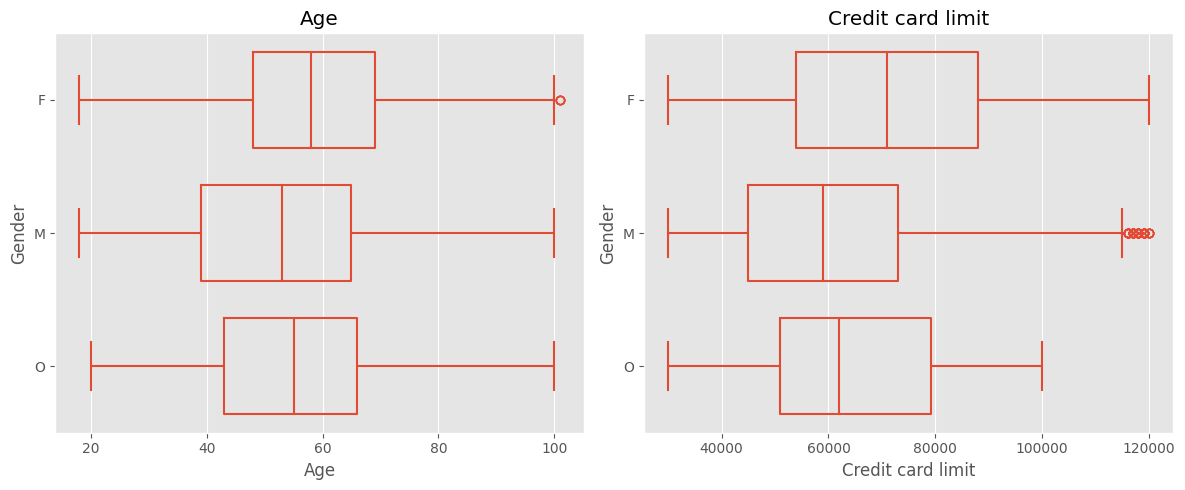

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(
    data=customers_raw[(customers_raw["age"] != 118)],
    x="age",
    y="gender",
    fill=False,
    gap=0.1,
    ax=axes[0],
)
axes[0].set_title("Age")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Gender")

sns.boxplot(
    data=customers_raw[(customers_raw["age"] != 118)],
    x="credit_card_limit",
    y="gender",
    fill=False,
    gap=0.1,
    ax=axes[1],
)
axes[1].set_title("Credit card limit")
axes[1].set_xlabel("Credit card limit")
axes[1].set_ylabel("Gender")

# Adjust layout
plt.tight_layout()
plt.show()

**Observações:**

- Removendo a idade igual a 118 anos, observa-se que a média e a mediana das variáveis ```age``` e ```credit_card_limit``` são próximas

- Para os clientes que a idade é igual a 118 anos, os campos  ```gender``` e ```credit_card_limit``` são faltantes

- O percentual de missings nos campos  ```gender``` e ```credit_card_limit``` é de 12.7941%, assim como o percentual de clientes com idade igual a 118 anos

A partir da análise serão realizadas as seguintes transformações nos dados:

- ```registered_on``` será convertido para datetime

- ```gender``` será transformado para o tipo inteiro. Os casos de missing serão atribuídos a categoria "Outros"

- Para os valores missings em ```gender``` e ```credit_card_limit``` a média será imputada. A média imputada será calculada sem os valores missings

- O campo  ```id``` será renomeado para ```customer_id```, afim de facilitar os futuros joins

- A partir de ```registered_on``` pode-se criar uma nova variável, o tempo (em dias) que o cliente se registrou

- ```flag_infos``` feature para indicar se os dados do cliente originalmente são missings ou a idade é igual a 118. O intuito desta feature é utilizar os dados posteriormente para a modelagem

Abaixo estão os passos de manipulação de ```customers.json```

In [25]:
customers_raw["flag_info"] = np.where(customers_raw["age"] != 118, 1, 0)

# Agrupar e calcular as estatísticas
customers_raw[["flag_info", "id", "age"]].groupby("flag_info").agg(
    {"id": "count", "age": "mean"}
).reset_index()

,flag_info,id,age
0,0,2175,118.000000
1,1,14825,54.393524


In [26]:
mean_age = customers_raw[customers_raw["age"] != 118]["age"].mean()
mean_credit_limit = customers_raw[customers_raw["age"] != 118][
    "credit_card_limit"
].mean()

In [27]:
customers = customers_raw.rename(columns={"id": "customer_id"})

In [28]:
# Convert registered_on to datetime
customers["registered_on"] = pd.to_datetime(
    customers["registered_on"], format="%Y%m%d", errors="coerce"
)

In [29]:
# Convert 'gender' to numeric type with default for missing/invalid values
gender_mapping = {"F": 0, "M": 1, "O": 2, None: 2}
customers["gender"] = customers["gender"].map(gender_mapping).fillna(2).astype(int)

In [30]:
# Replace invalid age value (118) with the mean of age
customers["age"] = customers["age"].replace(118, mean_age)

In [31]:
# Replace NaN in credit_card_limit with the mean of credit card limit
customers["credit_card_limit"] = customers["credit_card_limit"].fillna(
    mean_credit_limit
)

In [32]:
# Add new feature: number of days have been a customer
current_date = pd.Timestamp.now()
customers["days_as_customer"] = (current_date - customers["registered_on"]).dt.days

In [33]:
customers.head()

,age,registered_on,gender,customer_id,credit_card_limit,flag_info,days_as_customer
0,54.393524,2017-02-12,2,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,0,2864
1,55.000000,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.000000,1,2711
2,54.393524,2018-07-12,2,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,0,2349
3,75.000000,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,1,2778
4,54.393524,2017-08-04,2,a03223e636434f42ac4c3df47e8bac43,65404.991568,0,2691


In [34]:
customers.to_csv("../data/processed/customers.csv")

# 3 | Dataset transactions

In [35]:
transactions_raw = pd.read_json("../data/raw/transactions.json")
transactions_raw.head()

,event,account_id,value,time_since_test_start
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,"{'amount': None, 'offer id': '9b98b8c7a33c4b65...",0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,"{'amount': None, 'offer id': '0b1e1539f2cc45b7...",0.0
2,offer received,e2127556f4f64592b11af22de27a7932,"{'amount': None, 'offer id': '2906b810c7d44117...",0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,"{'amount': None, 'offer id': 'fafdcd668e3743c1...",0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,"{'amount': None, 'offer id': '4d5c57ea9a6940dd...",0.0


In [36]:
# Get shape and dtypes
transactions_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   event                  306534 non-null  object 
 1   account_id             306534 non-null  object 
 2   value                  306534 non-null  object 
 3   time_since_test_start  306534 non-null  float64
dtypes: float64(1), object(3)
memory usage: 9.4+ MB


In [37]:
# Check the unique keys in value
set(key for detail in transactions_raw["value"] if detail for key in detail.keys())

{'amount', 'offer id', 'offer_id', 'reward'}

In [38]:
# Transform the values json into dataframe
value_details = pd.json_normalize(transactions_raw["value"])
value_details.head()

,amount,offer id,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,None,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,None,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,None,NaN


No dataset acima observa-se dois campos que referenciam ao ID da oferta, ```offer id``` e ```offer_id```. O que leva a hipótese de que esses campos são iguais, mas podem ter sido extraídos de maneira inadequado. 

Para checar se eles são iguais será verficado se essas features são mutuamente exclusivas, considerando o seguinte racional:

- Ambas as features são nulas

- Uma das features não é nula

- Ambas as features não são nulas e diferentes

O último ponto é o mais crítico, pois indica que uma observação contém IDs de ofertas distintos, o que irá levar ao descarte da observação. Abaixo é realizada a análise para verificar a hipótese.

In [39]:
# Get the expanded dataset of transaction to have only one dataset to clean
transactions_value_details = pd.concat(
    [transactions_raw.drop(columns=["value"]), value_details], axis=1
)
transactions_value_details.head()

,event,account_id,time_since_test_start,amount,offer id,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,NaN,2906b810c7d4411798c6938adc9daaa5,None,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,NaN,fafdcd668e3743c1bb461111dcafc2a4,None,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,None,NaN


In [40]:
# Check the offer id and offer_id are equal or not
transactions_value_details["check_offer_id"] = transactions_value_details.apply(
    check_offer_ids, axis=1
)
transactions_value_details[["account_id", "check_offer_id"]].groupby(
    by="check_offer_id"
).count()

,account_id
check_offer_id,
flag_both_null,138953
flag_id_1_not_null,134002
flag_id_2_not_null,33579


A partir da tabela observa-se que nenhuma observação contem IDs de ofertas distintos. Dado isso pode-se combinar os campos, de forma a criar um único ```offer_id```. Para criar essa nova feature as features serão combinadas, i.e.:

- Quando ambas as features estiverem nulas o seu valor se mantém nulo

- Quando uma das features for não nula esse valor será atribuído a nova feature ```offer_id```

In [41]:
# Create the column with correct offer_id
transactions_value_details["combined_offer_id"] = transactions_value_details.apply(
    lambda row: row["offer id"] if pd.notna(row["offer id"]) else row["offer_id"],
    axis=1,
)
transactions_value_details.head()

,event,account_id,time_since_test_start,amount,offer id,offer_id,reward,check_offer_id,combined_offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,None,NaN,flag_id_1_not_null,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,NaN,flag_id_1_not_null,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,NaN,2906b810c7d4411798c6938adc9daaa5,None,NaN,flag_id_1_not_null,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,NaN,fafdcd668e3743c1bb461111dcafc2a4,None,NaN,flag_id_1_not_null,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,None,NaN,flag_id_1_not_null,4d5c57ea9a6940dd891ad53e9dbe8da0


In [42]:
# Check the percentage of missings
transactions_value_details.isna().mean() * 100

event                     0.000000
account_id                0.000000
time_since_test_start     0.000000
amount                   54.669629
offer id                 56.284784
offer_id                 89.045587
reward                   89.045587
check_offer_id            0.000000
combined_offer_id        45.330371
dtype: float64

In [43]:
transactions_value_details.to_csv("../data/processed/transactions_value_details.csv")

Observa-se que o número de missings na feature ```combined_offer_id``` se mantém alto. Antes de investigar a possível causa, algumas variáveis serão descartadas (pois não são mais necessárias) e outras serão renomeadas.

In [44]:
transactions_value_details.drop(
    columns={"offer_id", "offer id", "check_offer_id"}, inplace=True
)

In [45]:
transactions_value_details.rename(
    columns={"combined_offer_id": "offer_id", "account_id": "customer_id"}, inplace=True
)

In [46]:
# Percentage of events
transactions_value_details["event"].value_counts(
    normalize=True
) * 100

event
transaction        45.330371
offer received     24.883700
offer viewed       18.831516
offer completed    10.954413
Name: proportion, dtype: float64

Após os passos anteriores de manipulação, serão visualizados os dados de alguns clientes. O objetivo é compreender o que leva o ```offer_id``` ter um alto percentual de missings.

In [47]:
# Customer "78afa995795e4d85b5d9ceeca43f5fef"
transactions_value_details[
    transactions_value_details["customer_id"] == "78afa995795e4d85b5d9ceeca43f5fef"
].sort_values(by=["offer_id", "time_since_test_start"])

,event,customer_id,time_since_test_start,amount,reward,offer_id
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,7.00,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,9.00,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.00,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,0.25,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,5.50,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
150598,offer received,78afa995795e4d85b5d9ceeca43f5fef,17.00,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd
163375,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,17.00,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd
218394,offer completed,78afa995795e4d85b5d9ceeca43f5fef,21.25,NaN,10.0,ae264e3637204a6fb9bb56bc8210ddfd
201572,offer received,78afa995795e4d85b5d9ceeca43f5fef,21.00,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
218395,offer completed,78afa995795e4d85b5d9ceeca43f5fef,21.25,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d


Para o cliente ```78afa995795e4d85b5d9ceeca43f5fef``` observa-se que a feature ```offer_id``` é nula quando o evento é de transação. E quando o ID da oferta não é nulo a feature ```amount``` é.

In [48]:
# Customer "a03223e636434f42ac4c3df47e8bac43"
transactions_value_details[
    transactions_value_details["customer_id"] == "a03223e636434f42ac4c3df47e8bac43"
].sort_values(by=["offer_id", "time_since_test_start"])

,event,customer_id,time_since_test_start,amount,reward,offer_id
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.00,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
15562,offer viewed,a03223e636434f42ac4c3df47e8bac43,0.25,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
201573,offer received,a03223e636434f42ac4c3df47e8bac43,21.00,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
245125,offer received,a03223e636434f42ac4c3df47e8bac43,24.00,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
281785,offer viewed,a03223e636434f42ac4c3df47e8bac43,26.00,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
110829,offer received,a03223e636434f42ac4c3df47e8bac43,14.00,NaN,NaN,3f207df678b143eea3cee63160fa8bed
123539,offer viewed,a03223e636434f42ac4c3df47e8bac43,14.00,NaN,NaN,3f207df678b143eea3cee63160fa8bed
150599,offer received,a03223e636434f42ac4c3df47e8bac43,17.00,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
90553,transaction,a03223e636434f42ac4c3df47e8bac43,9.75,1.09,NaN,None
97700,transaction,a03223e636434f42ac4c3df47e8bac43,11.00,3.50,NaN,None


Para o cliente ```a03223e636434f42ac4c3df47e8bac43``` observa-se que a feature ```offer_id``` é nula quando o event é de transação. E quando o ID da oferta não é nulo a feature ```amount``` é.

Observa-se também que o cliente recebeu a oferta ```0b1e1539f2cc45b7b9fa7c272da2e1d7``` mais de uma vez (a feature ```time_since_test_start``` indica o tempo que o cliente recebeu, visualizou, etc a oferta). Dado isso pode-se inferir que um cliente pode ser impactado por uma oferta mais de uma vez e receber mais de uma oferta ao menos tempo.

In [49]:
# Customer "e2127556f4f64592b11af22de27a7932"
transactions_value_details[
    transactions_value_details["customer_id"] == "e2127556f4f64592b11af22de27a7932"
].sort_values(by=["offer_id", "time_since_test_start"])

,event,customer_id,time_since_test_start,amount,reward,offer_id
2,offer received,e2127556f4f64592b11af22de27a7932,0.00,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
20283,offer viewed,e2127556f4f64592b11af22de27a7932,0.75,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
110830,offer received,e2127556f4f64592b11af22de27a7932,14.00,NaN,NaN,3f207df678b143eea3cee63160fa8bed
150600,offer received,e2127556f4f64592b11af22de27a7932,17.00,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
171209,offer viewed,e2127556f4f64592b11af22de27a7932,17.50,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
225061,offer completed,e2127556f4f64592b11af22de27a7932,21.75,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
201574,offer received,e2127556f4f64592b11af22de27a7932,21.00,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
225059,offer viewed,e2127556f4f64592b11af22de27a7932,21.75,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
225062,offer completed,e2127556f4f64592b11af22de27a7932,21.75,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4
102635,transaction,e2127556f4f64592b11af22de27a7932,12.00,17.88,NaN,None


Para o cliente ```e2127556f4f64592b11af22de27a7932``` observa-se que a feature ```offer_id``` é nula quando o event é de transação. E quando o ID da oferta não é nulo a feature ```amount``` é.

A análise dos dados de 3 clientes leva a hipótese de que os eventos de transação não estão diretamente associados a uma oferta. Além disso a partir da análise as features ```amount``` pode ser definida como o valor gasto em uma transação.

Abaixo será checada a hipótese de que os eventos de transação não estão associados a uma oferta.

In [50]:
transactions_value_details["event"].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

In [51]:
event_transactions = transactions_value_details[
    transactions_value_details["event"] == "transaction"
]

associated_with_offer = event_transactions[event_transactions["offer_id"].notna()]
not_associated_with_offer = event_transactions[event_transactions["offer_id"].isna()]

print(f"Transações associadas a ofertas: {len(associated_with_offer)}")
print(f"Transações não associadas a ofertas: {len(not_associated_with_offer)}")

Transações associadas a ofertas: 0
Transações não associadas a ofertas: 138953


Observa-se que o total de eventos de transação é de 138953 e o total de eventos de transações com o ID da oferta nulo é de 138953. O que corrobora a hipótese de que os dados relativos a transações não estão diretamente associados a uma oferta.

Dado isso será necessário desenvolver uma proxy para associar os dados de transações aos IDs de ofertas. Para tal serão consideradas as seguintes features:

- ```time_since_test_start```: Do dataset ```transactions```, indica quando cada evento ocorreu em relação ao início do teste

- ```duration```: Do dataset ```offers```, indica o tempo de duração de uma oferta, i.e., o tempo que o cliente tem para utilizar a oferta

Vale ressaltar que a definição dada a ```duration``` ocorre porque uma oferta deve ter um tempo de vida útil, i.e., uma oferta tem um prazo de validade.

Para associar uma transação a uma oferta, considera-se uma janela de tempo que define o período em que a oferta pode ter influenciado a transação. As regras são:

1.	Início do período de influência:

    •	Quando uma oferta é recebida (```event = "offer_received"```), o tempo de início é: ```start_time = time_since_test_start```

2.	Fim do período de influência:

    •	O prazo de validade da oferta (```duration```) é contado a partir de ```start_time```: ```end_time = time_since_test_start + duration```

3.	Associação de transações:

    •	Se uma transação (```event = "transaction"```) ocorrer dentro do período de influência da oferta (```start_time <= time_since_test_start <= end_time```), a transação será associada ao ID da oferta.

Esse processo é repetido para cada ID de oferta, considerando o período de duração específico de cada uma.

Resumo: Para cada ID de oferta e eventos do cliente, verifica-se se a transação ocorreu no período de influência da oferta.

In [52]:
# Quick stats
offers["duration"].describe()

count    10.000000
mean      6.500000
std       2.321398
min       3.000000
25%       5.000000
50%       7.000000
75%       7.000000
max      10.000000
Name: duration, dtype: float64

In [53]:
# Quick stats
transactions_value_details["time_since_test_start"].describe()

count    306534.000000
mean         15.265956
std           8.346930
min           0.000000
25%           7.750000
50%          17.000000
75%          22.000000
max          29.750000
Name: time_since_test_start, dtype: float64

In [54]:
# Apply the proxy
transactions_with_offers = associate_transactions_to_offers(
    transactions_value_details, offers[["offer_id", "duration"]]
)

In [55]:
transactions_with_offers.head()

,event,customer_id,time_since_test_start,amount,reward,offer_id,duration
247879,offer received,0009655768c64bdeb2e877511632db8f,24.0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,7.0
258884,offer completed,0009655768c64bdeb2e877511632db8f,24.0,NaN,2.0,2906b810c7d4411798c6938adc9daaa5,7.0
113605,offer received,0009655768c64bdeb2e877511632db8f,14.0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,4.0
139992,offer viewed,0009655768c64bdeb2e877511632db8f,15.5,NaN,NaN,3f207df678b143eea3cee63160fa8bed,4.0
55972,offer received,0009655768c64bdeb2e877511632db8f,7.0,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,3.0


In [56]:
transactions_with_offers.to_csv("../data/processed/transactions_with_offers.csv")

Após realizar a associação dos eventos de transação com uma oferta, será realizado o processo de feature engineering. 

As seguintes features serão criadas:

- ```time_to_view```: tempo que o cliente leva para visualizar uma oferta, i.e., tempo entre receber uma oferta e visualizá-la

- ```time_to_open```: tempo que o cliente leva para completar uma oferta, i.e., tempo entre visualizar uma oferta e completá-la

- ```event```: serão criadas variáveis dummies para essa feature

In [57]:
transactions_with_offers_to_time = transactions_with_offers.copy()
transactions_with_offers_to_time.event.value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

In [58]:
# Apply function to get times
transactions_time = calculate_time(transactions_with_offers_to_time)
transactions_time.head()

,customer_id,offer_id,time_to_view,time_to_complete
247879,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.5,NaN
55972,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,NaN
153401,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,2.0,NaN
204340,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.5,NaN


In [59]:
transactions_time.to_csv("../data/processed/transactions_time.csv")

In [60]:
# Get dummies for events
event_dummies = pd.get_dummies(
    transactions_with_offers["event"], prefix="event", dtype=int
)
transactions_with_dummies = pd.concat([transactions_with_offers, event_dummies], axis=1)
transactions_with_dummies.head()

,event,customer_id,time_since_test_start,amount,reward,offer_id,duration,event_offer completed,event_offer received,event_offer viewed,event_transaction
247879,offer received,0009655768c64bdeb2e877511632db8f,24.0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,7.0,0,1,0,0
258884,offer completed,0009655768c64bdeb2e877511632db8f,24.0,NaN,2.0,2906b810c7d4411798c6938adc9daaa5,7.0,1,0,0,0
113605,offer received,0009655768c64bdeb2e877511632db8f,14.0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,4.0,0,1,0,0
139992,offer viewed,0009655768c64bdeb2e877511632db8f,15.5,NaN,NaN,3f207df678b143eea3cee63160fa8bed,4.0,0,0,1,0
55972,offer received,0009655768c64bdeb2e877511632db8f,7.0,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,3.0,0,1,0,0


In [61]:
transactions_processed = transactions_with_dummies.merge(
    transactions_time, on=["customer_id", "offer_id"], how="inner"
)
transactions_processed.head()

,event,customer_id,time_since_test_start,amount,reward,offer_id,duration,event_offer completed,event_offer received,event_offer viewed,event_transaction,time_to_view,time_to_complete
0,offer received,0009655768c64bdeb2e877511632db8f,24.0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,7.0,0,1,0,0,NaN,NaN
1,offer completed,0009655768c64bdeb2e877511632db8f,24.0,NaN,2.0,2906b810c7d4411798c6938adc9daaa5,7.0,1,0,0,0,NaN,NaN
2,offer received,0009655768c64bdeb2e877511632db8f,14.0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,4.0,0,1,0,0,1.5,NaN
3,offer viewed,0009655768c64bdeb2e877511632db8f,15.5,NaN,NaN,3f207df678b143eea3cee63160fa8bed,4.0,0,0,1,0,1.5,NaN
4,offer received,0009655768c64bdeb2e877511632db8f,7.0,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,3.0,0,1,0,0,1.0,NaN


In [62]:
transactions_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396939 entries, 0 to 396938
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   event                  396939 non-null  object 
 1   customer_id            396939 non-null  object 
 2   time_since_test_start  396939 non-null  float64
 3   amount                 166499 non-null  float64
 4   reward                 46152 non-null   float64
 5   offer_id               396939 non-null  object 
 6   duration               230440 non-null  float64
 7   event_offer completed  396939 non-null  int64  
 8   event_offer received   396939 non-null  int64  
 9   event_offer viewed     396939 non-null  int64  
 10  event_transaction      396939 non-null  int64  
 11  time_to_view           346402 non-null  float64
 12  time_to_complete       188208 non-null  float64
dtypes: float64(6), int64(4), object(3)
memory usage: 39.4+ MB


In [63]:
transactions_processed = transactions_processed.rename(columns={
    "event_offer completed": "event_offer_completed",
    "event_offer received": "event_offer_received",
    "event_offer viewed": "event_offer_viewed",
})
transactions_processed.head(3)

,event,customer_id,time_since_test_start,amount,reward,offer_id,duration,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,time_to_view,time_to_complete
0,offer received,0009655768c64bdeb2e877511632db8f,24.0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,7.0,0,1,0,0,NaN,NaN
1,offer completed,0009655768c64bdeb2e877511632db8f,24.0,NaN,2.0,2906b810c7d4411798c6938adc9daaa5,7.0,1,0,0,0,NaN,NaN
2,offer received,0009655768c64bdeb2e877511632db8f,14.0,NaN,NaN,3f207df678b143eea3cee63160fa8bed,4.0,0,1,0,0,1.5,NaN


In [64]:
transactions_processed.to_csv("../data/processed/transactions_processed.csv")

# 4 | Join datasets

Dois datasets serão criados:

- ```customers_offers_agg```: informações agregadas a nível de  ```offers``` e ```customers```

- ```customers_agg```: informações agregadas a nível de ```customers```

In [65]:
transactions_processed = pd.read_csv("../data/processed/transactions_processed.csv")

In [66]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   age                17000 non-null  float64       
 1   registered_on      17000 non-null  datetime64[ns]
 2   gender             17000 non-null  int64         
 3   customer_id        17000 non-null  object        
 4   credit_card_limit  17000 non-null  float64       
 5   flag_info          17000 non-null  int64         
 6   days_as_customer   17000 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 929.8+ KB


In [67]:
customers_transactions = customers.merge(
    transactions_processed, on=["customer_id"], how="left"
)
customers_transactions.head()

,age,registered_on,gender,customer_id,credit_card_limit,flag_info,days_as_customer,Unnamed: 0,event,time_since_test_start,amount,reward,offer_id,duration,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,time_to_view,time_to_complete
0,54.393524,2017-02-12,2,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,0,2864,161910.0,offer received,14.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,0.0,1.0,0.0,0.0,0.5,NaN
1,54.393524,2017-02-12,2,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,0,2864,161911.0,offer viewed,14.5,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,0.0,0.0,1.0,0.0,0.5,NaN
2,54.393524,2017-02-12,2,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,0,2864,161912.0,offer received,21.0,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,0.0,1.0,0.0,0.0,0.0,2.0
3,54.393524,2017-02-12,2,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,0,2864,161913.0,offer viewed,21.0,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,0.0,0.0,1.0,0.0,0.0,2.0
4,54.393524,2017-02-12,2,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,0,2864,161914.0,offer completed,23.0,NaN,3.0,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,1.0,0.0,0.0,0.0,0.0,2.0


In [68]:
customers_transactions_offers = customers_transactions.merge(
    offers.drop(columns="duration"), on="offer_id", how="left"
)

Da tabela acima observa-se que o cliente pode receber uma mesma oferta mais de uma vez.

In [69]:
customers_transactions_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396945 entries, 0 to 396944
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   age                    396945 non-null  float64       
 1   registered_on          396945 non-null  datetime64[ns]
 2   gender                 396945 non-null  int64         
 3   customer_id            396945 non-null  object        
 4   credit_card_limit      396945 non-null  float64       
 5   flag_info              396945 non-null  int64         
 6   days_as_customer       396945 non-null  int64         
 7   Unnamed: 0             396939 non-null  float64       
 8   event                  396939 non-null  object        
 9   time_since_test_start  396939 non-null  float64       
 10  amount                 166499 non-null  float64       
 11  reward                 46152 non-null   float64       
 12  offer_id               396939 non-null  obje

In [70]:
customers_transactions_offers["time_to_view"] = customers_transactions_offers[
    "time_to_view"
].fillna(0)
customers_transactions_offers["time_to_complete"] = customers_transactions_offers[
    "time_to_complete"
].fillna(0)

Sumarizando os dados para cada cliente

In [71]:
customer_offers_agg = (
    customers_transactions_offers.groupby(["customer_id", "offer_id"])
    .agg(
        total_amount=("amount", "sum"),
        total_reward=("reward", "sum"),
        total_offer_completed=("event_offer_completed", "sum"),
        total_offer_received=("event_offer_received", "sum"),
        total_offer_viewed=("event_offer_viewed", "sum"),
        total_transaction=("event_transaction", "sum"),
        total_social=("social", "sum"),
        total_mobile=("mobile", "sum"),
        total_email=("email", "sum"),
        total_web=("web", "sum"),
        total_bogo=("bogo", "sum"),
        total_discount=("discount", "sum"),
        total_informational=("informational", "sum"),
        agv_time_to_view=("time_to_view", "mean"),
        avg_time_to_complete=("time_to_complete", "mean"),
        credit_card_limit=("credit_card_limit", "mean"),
        days_as_customer=("days_as_customer", "mean"),
        avg_amount=("amount", "mean"),
        min_value=("min_value", "mean")
    )
    .reset_index()
    .sort_values(by=["customer_id", "offer_id"])
)

In [72]:
customer_offers_agg["viewed_ratio"] = customer_offers_agg["total_offer_viewed"] / customer_offers_agg["total_offer_received"]
customer_offers_agg["completed_ratio"] = customer_offers_agg["total_offer_completed"] / customer_offers_agg["total_offer_viewed"]
customer_offers_agg["completed_ratio"] = customer_offers_agg["completed_ratio"].replace(np.inf, 0)
customer_offers_agg.head()

,customer_id,offer_id,total_amount,total_reward,total_offer_completed,total_offer_received,total_offer_viewed,total_transaction,total_social,total_mobile,...,total_discount,total_informational,agv_time_to_view,avg_time_to_complete,credit_card_limit,days_as_customer,avg_amount,min_value,viewed_ratio,completed_ratio
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.00,2.0,1.0,1.0,0.0,0.0,0.0,2.0,...,2.0,0.0,0.0,0.0,72000.0,2796.0,NaN,10.0,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.00,0.0,0.0,1.0,1.0,0.0,0.0,2.0,...,0.0,2.0,1.5,0.0,72000.0,2796.0,NaN,0.0,1.0,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16,0.0,0.0,1.0,1.0,1.0,3.0,3.0,...,0.0,3.0,1.0,0.0,72000.0,2796.0,22.160,0.0,1.0,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,8.57,5.0,1.0,1.0,1.0,1.0,4.0,4.0,...,0.0,0.0,2.0,0.0,72000.0,2796.0,8.570,5.0,1.0,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,96.87,2.0,1.0,1.0,1.0,6.0,9.0,9.0,...,9.0,0.0,1.5,0.0,72000.0,2796.0,16.145,10.0,1.0,1.0


In [73]:
customers_gender = customers_transactions_offers[["customer_id", "gender", "flag_info"]]
customers_gender.drop_duplicates(inplace=True)

/var/folders/m6/mv_nh0ks2n98r3d6kxb3tdh40000gn/T/ipykernel_4766/2840580951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_gender.drop_duplicates(inplace=True)


In [74]:
customer_offers_agg_final = customer_offers_agg.merge(
    customers_gender,
    on="customer_id",
    how="inner",
)
customer_offers_agg_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63288 entries, 0 to 63287
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            63288 non-null  object 
 1   offer_id               63288 non-null  object 
 2   total_amount           63288 non-null  float64
 3   total_reward           63288 non-null  float64
 4   total_offer_completed  63288 non-null  float64
 5   total_offer_received   63288 non-null  float64
 6   total_offer_viewed     63288 non-null  float64
 7   total_transaction      63288 non-null  float64
 8   total_social           63288 non-null  float64
 9   total_mobile           63288 non-null  float64
 10  total_email            63288 non-null  float64
 11  total_web              63288 non-null  float64
 12  total_bogo             63288 non-null  float64
 13  total_discount         63288 non-null  float64
 14  total_informational    63288 non-null  float64
 15  ag

In [75]:
customer_offers_agg_final.head(3)

,customer_id,offer_id,total_amount,total_reward,total_offer_completed,total_offer_received,total_offer_viewed,total_transaction,total_social,total_mobile,...,agv_time_to_view,avg_time_to_complete,credit_card_limit,days_as_customer,avg_amount,min_value,viewed_ratio,completed_ratio,gender,flag_info
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.00,2.0,1.0,1.0,0.0,0.0,0.0,2.0,...,0.0,0.0,72000.0,2796.0,NaN,10.0,0.0,0.0,1,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.00,0.0,0.0,1.0,1.0,0.0,0.0,2.0,...,1.5,0.0,72000.0,2796.0,NaN,0.0,1.0,0.0,1,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,22.16,0.0,0.0,1.0,1.0,1.0,3.0,3.0,...,1.0,0.0,72000.0,2796.0,22.16,0.0,1.0,0.0,1,1


In [76]:
customer_offers_agg_final.to_csv(
    "../data/processed/customer_offers_agg.csv", index=False
)

customer_offers_agg_final.to_csv(
    "../data/final/customer_offers_agg.csv", index=False
)

Sumarizando os dados a nível de cliente

In [77]:
customer_agg = (
    customer_offers_agg_final.groupby(by=["customer_id"])
    .agg(
        total_amount=("total_amount", "sum"),
        total_reward=("total_reward", "sum"),
        total_offer_completed=("total_offer_completed", "sum"),
        total_offer_received=("total_offer_received", "sum"),
        total_offer_viewed=("total_offer_viewed", "sum"),
        total_transaction=("total_transaction", "sum"),
        total_social=("total_social", "sum"),
        total_mobile=("total_mobile", "sum"),
        total_email=("total_email", "sum"),
        total_web=("total_web", "sum"),
        total_bogo=("total_bogo", "sum"),
        total_discount=("total_discount", "sum"),
        total_informational=("total_informational", "sum"),
        agv_time_to_view=("agv_time_to_view", "mean"),
        avg_time_to_complete=("avg_time_to_complete", "mean"),
        credit_card_limit=("credit_card_limit", "mean"),
        days_as_customer=("days_as_customer", "mean"),
        avg_amount=("avg_amount", "mean"),
        min_value=("min_value", "mean")
    )
    .reset_index()
    .sort_values(by="customer_id")
)
customer_agg.head()

,customer_id,total_amount,total_reward,total_offer_completed,total_offer_received,total_offer_viewed,total_transaction,total_social,total_mobile,total_email,total_web,total_bogo,total_discount,total_informational,agv_time_to_view,avg_time_to_complete,credit_card_limit,days_as_customer,avg_amount,min_value
0,0009655768c64bdeb2e877511632db8f,127.60,9.0,3.0,5.0,4.0,8.0,16.0,20.0,20.0,17.0,4.0,11.0,5.0,1.2000,0.00000,72000.000000,2796.0,15.625000,5.00
1,00116118485d4dfda04fdbaba9a87b5c,0.00,0.0,0.0,4.0,4.0,0.0,8.0,8.0,8.0,8.0,8.0,0.0,0.0,2.1250,0.00000,65404.991568,2427.0,NaN,5.00
2,0011e0d4e6b944f998e987f904e8c1e5,65.97,13.0,3.0,5.0,5.0,4.0,6.0,14.0,17.0,15.0,6.0,7.0,4.0,0.6500,2.25000,57000.000000,2533.0,14.971667,6.40
3,0020c2b971eb4e9188eac86d93036a77,298.86,18.0,5.0,7.0,4.0,12.0,28.0,28.0,28.0,25.0,4.0,22.0,2.0,1.8750,1.09375,90000.000000,3209.0,24.905000,7.50
4,0020ccbbb6d84e358d3414a3ff76cffd,137.78,13.0,3.0,4.0,4.0,11.0,17.0,22.0,22.0,19.0,12.0,7.0,3.0,0.9375,1.06250,60000.000000,2957.0,13.304375,4.25


In [78]:
customer_agg_final = customer_agg.merge(
    customers_gender,
    on="customer_id",
    how="inner",
)
customer_agg_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16994 entries, 0 to 16993
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            16994 non-null  object 
 1   total_amount           16994 non-null  float64
 2   total_reward           16994 non-null  float64
 3   total_offer_completed  16994 non-null  float64
 4   total_offer_received   16994 non-null  float64
 5   total_offer_viewed     16994 non-null  float64
 6   total_transaction      16994 non-null  float64
 7   total_social           16994 non-null  float64
 8   total_mobile           16994 non-null  float64
 9   total_email            16994 non-null  float64
 10  total_web              16994 non-null  float64
 11  total_bogo             16994 non-null  float64
 12  total_discount         16994 non-null  float64
 13  total_informational    16994 non-null  float64
 14  agv_time_to_view       16994 non-null  float64
 15  av

In [79]:
customer_agg.sort_values(by="customer_id").head()

,customer_id,total_amount,total_reward,total_offer_completed,total_offer_received,total_offer_viewed,total_transaction,total_social,total_mobile,total_email,total_web,total_bogo,total_discount,total_informational,agv_time_to_view,avg_time_to_complete,credit_card_limit,days_as_customer,avg_amount,min_value
0,0009655768c64bdeb2e877511632db8f,127.60,9.0,3.0,5.0,4.0,8.0,16.0,20.0,20.0,17.0,4.0,11.0,5.0,1.2000,0.00000,72000.000000,2796.0,15.625000,5.00
1,00116118485d4dfda04fdbaba9a87b5c,0.00,0.0,0.0,4.0,4.0,0.0,8.0,8.0,8.0,8.0,8.0,0.0,0.0,2.1250,0.00000,65404.991568,2427.0,NaN,5.00
2,0011e0d4e6b944f998e987f904e8c1e5,65.97,13.0,3.0,5.0,5.0,4.0,6.0,14.0,17.0,15.0,6.0,7.0,4.0,0.6500,2.25000,57000.000000,2533.0,14.971667,6.40
3,0020c2b971eb4e9188eac86d93036a77,298.86,18.0,5.0,7.0,4.0,12.0,28.0,28.0,28.0,25.0,4.0,22.0,2.0,1.8750,1.09375,90000.000000,3209.0,24.905000,7.50
4,0020ccbbb6d84e358d3414a3ff76cffd,137.78,13.0,3.0,4.0,4.0,11.0,17.0,22.0,22.0,19.0,12.0,7.0,3.0,0.9375,1.06250,60000.000000,2957.0,13.304375,4.25


In [80]:
customer_agg_final.to_csv(
    "../data/processed/customer_agg.csv", index=False
)

customer_agg_final.to_csv(
    "../data/final/customer_agg.csv", index=False
)